# The Scalar Wave Equation: Creating an Einstein Toolkit thorn

### NRPy+ Source Code for this module:[ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py) and [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py), which are fully documented in the [previous NRPy+ tutorial module on using NRPy+ to construct the Weyl scalars and invariants as SymPy expressions](Tutorial-ScalarWave.ipynb).


The goal of this tutorial is to construct an Einstein Toolkit (ETK) thorn that will evolve some initial data according to the scalar wave equation, subject to appropriate boundary conditions. In a [previous tutorial](Tutorial-ScalarWave.ipynb), we contructed the evolution equations and initial data to do this. This thorn should function identically to the $\text{WaveToy}$ thorns included in the Einstein Toolkit (ETK).

We will approach this in two steps.

1. Call on NRPy+ to convert the SymPy expressions for the initial data/evolution equations into one C-code kernel.
1. Write the C code and build up the needed Einstein Toolkit infrastructure (i.e., the .ccl files).

## Evolving the Scalar Wave equation

### Step 1: Call on NRPy+ to convert the SymPy expressions for the Scalar Wave RHS a C-code kernel. 

After importing the core modules, we will set $\text{GridFuncMemAccess}$ to $\text{ETK}$. The scalar wave right-hand sides are already built by [ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py), so we can simply import them to use here. We will also need to instruct the system to create the directories for our thorn.

In [1]:
# Step 1a: Import needed NRPy+ core modules:
import NRPy_param_funcs as par
import indexedexp as ixp
import grid as gri
import finite_difference as fin
from outputC import *
import loop

# Step 1b: This is an Einstein Toolkit (ETK) thorn. Here we
#          tell NRPy+ that gridfunction memory access will 
#          therefore be in the "ETK" style.
par.set_parval_from_str("grid::GridFuncMemAccess","ETK")

# Step 1c: Set the finite differencing order. 
#         IMPORTANT: If you set FD_CENTDERIVS_ORDER to 8, be sure to use
#                    the parameter files and scripts in the directory:
#                    WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTest
#                    If you set FD_CENTDERIVS_ORDER to 4, be sure to use
#                    the parameter files and scripts in the directory:
#                    WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",4) # SET TO EIGHTH ORDER

# Step 1d: Call the ScalarWave_RHSs() function from within the
#          ScalarWave/ScalarWave_RHSs.py module. 
#          This sets swrhs.uu_rhs and swrhs.vv_rhs.
import ScalarWave.ScalarWave_RHSs as swrhs
swrhs.ScalarWave_RHSs()

Now, we need to output these expressions to C code. We will do this the same way as in the Weyl scalars ETK tutorial: export these to a .h file, which can then be included in a main .c file to do the calculations.

In [2]:
# Step 2: Register uu_rhs and vv_rhs gridfunctions so 
#         they can be written to by NRPy.
uu_rhs,vv_rhs = gri.register_gridfunctions("AUX",["uu_rhs","vv_rhs"])

# Step 3: Create the C code output kernel.
scalar_RHSs_to_print = [\
                        lhrh(lhs=gri.gfaccess("out_gfs","uu_rhs"),rhs=swrhs.uu_rhs),\
                        lhrh(lhs=gri.gfaccess("out_gfs","vv_rhs"),rhs=swrhs.vv_rhs),]
scalar_RHSs_CcodeKernel = fin.FD_outputC("returnstring",scalar_RHSs_to_print)

scalar_RHSs_looped = loop.loop(["i2","i1","i0"],["cctk_nghostzones[2]","cctk_nghostzones[1]","cctk_nghostzones[0]"],\
                               ["cctk_lsh[2]-cctk_nghostzones[2]","cctk_lsh[1]-cctk_nghostzones[1]",\
                                "cctk_lsh[0]-cctk_nghostzones[0]"],\
                               ["1","1","1"],["#pragma omp parallel for","",""],"",scalar_RHSs_CcodeKernel)

# Step 4: Create directories for the thorn if they don't exist.
!mkdir WaveToyNRPy     2>/dev/null # 2>/dev/null: Don't throw an error if the directory already exists.
!mkdir WaveToyNRPy/src 2>/dev/null # 2>/dev/null: Don't throw an error if the directory already exists.

# Step 5: Write the C code kernel to file.
with open("WaveToyNRPy/src/ScalarWave_RHSs.h", "w") as file:
    file.write(str(scalar_RHSs_looped))

with open("WaveToyNRPy/src/NRPy_params.h", "w") as file:
    file.write("#define FD_CENTDERIVS_ORDER "+str(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER"))+"\n")

### Step 2: Interfacing with the Einstein Toolkit

#### Step 2a: Constructing the Einstein Toolkit calling functions that include the C code kernels.

Now that we have generated the C code kernel *WaveToyNRPy.c*, we will need to write C code to call these header files that we have output. To do this, we can follow the examples of WaveToyC and our Weyl Scalar ETK thorn. Functions defined by these files will be called by the Einstein Toolkit scheduler.

In [3]:
%%writefile WaveToyNRPy/src/WaveToyNRPy.c
#include <math.h>
#include <stdio.h>

#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "Symmetry.h"

#include "NRPy_params.h"

void WaveToyNRPy_check_params(CCTK_ARGUMENTS) {
    DECLARE_CCTK_ARGUMENTS;

    if( (cctk_nghostzones[0] != FD_CENTDERIVS_ORDER/2) || 
        (cctk_nghostzones[1] != FD_CENTDERIVS_ORDER/2) || 
        (cctk_nghostzones[2] != FD_CENTDERIVS_ORDER/2) ) {
            char error_string[200];
            sprintf(error_string,"WaveToyNRPy_check_params: expected ghost_size to be set to %d , but found ghostxyz = %d %d %d\n",
                    FD_CENTDERIVS_ORDER/2,cctk_nghostzones[0],cctk_nghostzones[1],cctk_nghostzones[2]);
            CCTK_WARN (0, error_string);
    }
}

void WaveToyNRPy_set_rhs(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  
  const CCTK_REAL invdx0 = 1.0 / (CCTK_DELTA_SPACE(0));
  const CCTK_REAL invdx1 = 1.0 / (CCTK_DELTA_SPACE(1));
  const CCTK_REAL invdx2 = 1.0 / (CCTK_DELTA_SPACE(2));
  
#include "ScalarWave_RHSs.h" 
}

/* Boundary Condition code adapted from WaveToyC thorn in ETK, implementing built-in
 * ETK BC functionality
 */
void WaveToyNRPy_SelectBCs(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  const char *bctype;


  bctype = NULL;
  if (CCTK_EQUALS(bound,"flat") || CCTK_EQUALS(bound,"static") ||
      CCTK_EQUALS(bound,"radiation") || CCTK_EQUALS(bound,"robin") ||
      CCTK_EQUALS(bound,"none"))
  {
    bctype = bound;
  }
  else if (CCTK_EQUALS(bound,"zero"))
  {
    bctype = "scalar";
  }

  /* Uses all default arguments, so invalid table handle -1 can be passed */
  if (bctype && Boundary_SelectVarForBC (cctkGH, CCTK_ALL_FACES, 1, -1,
                                         "WaveToyNRPy::uuGF", bctype) < 0)
  {
    CCTK_WARN (0, "ScalarWave_Boundaries: Error selecting boundary condition");
  }
  if (bctype && Boundary_SelectVarForBC (cctkGH, CCTK_ALL_FACES, 1, -1,
                                         "WaveToyNRPy::vvGF", bctype) < 0)
  {
    CCTK_WARN (0, "ScalarWave_Boundaries: Error selecting boundary condition");
  }
}

void WaveToyNRPy_InitSymBound(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
      
  int sym[3];

  sym[0] = 1;
  sym[1] = 1;
  sym[2] = 1;

  SetCartSymVN(cctkGH, sym,"WaveToyNRPy::uuGF");
  SetCartSymVN(cctkGH, sym,"WaveToyNRPy::vvGF");

  return;
}

void WaveToyNRPy_RegisterVars(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  
  CCTK_INT ierr CCTK_ATTRIBUTE_UNUSED = 0;
  /* Register all the evolved grid functions with MoL */
  ierr += MoLRegisterEvolved(CCTK_VarIndex("WaveToyNRPy::uuGF"),  CCTK_VarIndex("WaveToyNRPy::uu_rhsGF"));
  ierr += MoLRegisterEvolved(CCTK_VarIndex("WaveToyNRPy::vvGF"),  CCTK_VarIndex("WaveToyNRPy::vv_rhsGF"));
  /* Register all the evolved Array functions with MoL */
  return;
}

Writing WaveToyNRPy/src/WaveToyNRPy.c


#### Step 2b: CCL files - Define how this module interacts and interfaces with the larger Einstein Toolkit infrastructure

Writing a module ("thorn") within the Einstein Toolkit requires that three "ccl" files be constructed, all in the root directory of the thorn:

1. $\text{interface.ccl}$: defines the gridfunction groups needed, and provides keywords denoting what this thorn provides and what it should inherit from other thorns.
1. $\text{param.ccl}$: specifies free parameters within the thorn.
1. $\text{schedule.ccl}$: allocates storage for gridfunctions, defines how the thorn's functions should be scheduled in a broader simulation, and specifies the regions of memory written to or read from gridfunctions.

We will start with the file $\text{interface.ccl}$. This file governs the interaction between this thorn and others; more information can be found in the [official Einstein Toolkit documentation](http://cactuscode.org/documentation/referencemanual/ReferenceManualch8.html#x12-260000C2.2). 
With "implements", we give our thorn its unique name. By "inheriting" other thorns, we tell the Toolkit that we will rely on variables that exist within those functions. Then, we tell the toolkit that we want the scalars $\text{uuGF}$ and $\text{vvGF}$ to be visible to other thorns by using the keyword "public". 

In [4]:
%%writefile WaveToyNRPy/interface.ccl
implements: WaveToyNRPy

inherits: Boundary grid

USES INCLUDE: loopcontrol.h
USES INCLUDE: Symmetry.h
USES INCLUDE: Boundary.h
    
CCTK_INT FUNCTION MoLRegisterEvolved(CCTK_INT IN EvolvedIndex, CCTK_INT IN RHSIndex)
USES FUNCTION MoLRegisterEvolved

CCTK_INT FUNCTION GetBoundarySpecification(CCTK_INT IN size, CCTK_INT OUT ARRAY nboundaryzones, CCTK_INT OUT ARRAY is_internal, CCTK_INT OUT ARRAY is_staggered, CCTK_INT OUT ARRAY shiftout)
USES FUNCTION GetBoundarySpecification

CCTK_INT FUNCTION SymmetryTableHandleForGrid(CCTK_POINTER_TO_CONST IN cctkGH)
USES FUNCTION SymmetryTableHandleForGrid

CCTK_INT FUNCTION Boundary_SelectGroupForBC(CCTK_POINTER_TO_CONST IN GH, CCTK_INT IN faces, CCTK_INT IN boundary_width, CCTK_INT IN table_handle, CCTK_STRING IN group_name, CCTK_STRING IN bc_name)
USES FUNCTION Boundary_SelectGroupForBC

CCTK_INT FUNCTION Boundary_SelectVarForBC(CCTK_POINTER_TO_CONST IN GH, CCTK_INT IN faces, CCTK_INT IN boundary_width, CCTK_INT IN table_handle, CCTK_STRING IN var_name, CCTK_STRING IN bc_name)
USES FUNCTION Boundary_SelectVarForBC

public:
cctk_real scalar_fields_rhs type = GF Timelevels=3 tags='tensortypealias="Scalar"'
{
  uu_rhsGF,vv_rhsGF
} "The evolved scalar fields"

public:
cctk_real scalar_fields type = GF Timelevels=3 tags='tensortypealias="Scalar"'
{
  uuGF,vvGF
} "The evolved scalar fields"


Writing WaveToyNRPy/interface.ccl


We will now write the file $\text{param.ccl}$. This file allows the listed parameters to be set at runtime. We also give allowed ranges and default values for each parameter. More information on this file's syntax can be found in the [official Einstein Toolkit documentation](http://cactuscode.org/documentation/referencemanual/ReferenceManualch8.html#x12-265000C2.3). We first set a Keyword to determine our boundary conditions; this is not implemented yet, but more options can be added later. We also set the number of timelevels we will store in memory.

In [5]:
%%writefile WaveToyNRPy/param.ccl
shares: MethodOfLines

USES CCTK_INT MoL_Num_Evolved_Vars
USES CCTK_INT MoL_Num_ArrayEvolved_Vars

restricted:
CCTK_INT SimpleWave_MaxNumEvolvedVars "Number of evolved variables used by this thorn" ACCUMULATOR-BASE=MethodofLines::MoL_Num_Evolved_Vars STEERABLE=RECOVER
{
  2:2 :: "Number of evolved variables used by this thorn"
} 2

restricted:
CCTK_INT SimpleWave_MaxNumArrayEvolvedVars "Number of Array evolved variables used by this thorn" ACCUMULATOR-BASE=MethodofLines::MoL_Num_ArrayEvolved_Vars STEERABLE=RECOVER
{
  0:0 :: "Number of Array evolved variables used by this thorn"
} 0

restricted:
KEYWORD bound "Type of boundary condition to use"
{
  "flat"      :: "Flat (von Neumann, n grad phi = 0) boundary condition"
  "static"    :: "Static (Dirichlet, dphi/dt=0) boundary condition"
  "radiation" :: "Radiation boundary condition"
  "robin"     :: "Robin (phi(r) = C/r) boundary condition"
  "zero"      :: "Zero (Dirichlet, phi=0) boundary condition"
  "none"      :: "Apply no boundary condition"
} "static"

restricted:
CCTK_INT timelevels "Number of active timelevels" STEERABLE=RECOVER
{
  0:3 :: ""
} 3

restricted:
CCTK_REAL wavespeed "The speed at which the wave propagates"
{
 *:* :: "Wavespeed as a multiple of c"
} 1.0

Writing WaveToyNRPy/param.ccl


Finally, we will write the file $\text{schedule.ccl}$; its official documentation is found [here](http://cactuscode.org/documentation/referencemanual/ReferenceManualch8.html#x12-268000C2.4). This file dictates when the various parts of the thorn will be run. We first assign storage for both scalar gridfunctions, and then specify that we want our code run 

In [6]:
%%writefile WaveToyNRPy/schedule.ccl
STORAGE: scalar_fields_rhs[timelevels]
STORAGE: scalar_fields[timelevels]

schedule WaveToyNRPy_InitSymBound at BASEGRID
{
  LANG: C
  OPTIONS: global
} "Schedule symmetries"

schedule WaveToyNRPy_check_params at CCTK_PARAMCHECK
{
  LANG: C
  OPTIONS: global
} "Check sanity of parameters"

schedule WaveToyNRPy_set_rhs as WaveToy_Evolution IN MoL_CalcRHS
{
  LANG: C
  READS: uuGF(Everywhere)
  READS: vvGF(Everywhere)
  WRITES: uu_rhsGF(Interior)
  WRITES: VV_rhsGF(Interior)
    # FIXME: Add syncs
} "Evolution of 3D wave equation"

schedule WaveToyNRPy_SelectBCs in MoL_PostStep
{
  LANG: C
  OPTIONS: level
  SYNC: scalar_fields
} "Boundaries of 3D wave equation"

schedule GROUP ApplyBCs as WaveToyNRPy_ApplyBCs in MoL_PostStep after WaveToyNRPy_SelectBCs
{
} "Apply boundary conditions"


schedule GROUP ApplyBCs as WaveToyNRPy_ApplyBCs at POSTRESTRICT
{
} "Apply boundary conditions"

schedule WaveToyNRPy_RegisterVars in MoL_Register
{
  LANG: C
  OPTIONS: meta
} "Register Variables for MoL"


Writing WaveToyNRPy/schedule.ccl


#### Step 2c: Add the C file to Einstein Toolkit compilation list.

We will also need $\text{make.code.defn}$, which indicates the list of files that need to be compiled. This thorn only has the one C file to compile.

In [7]:
%%writefile WaveToyNRPy/src/make.code.defn
SRCS = WaveToyNRPy.c

Writing WaveToyNRPy/src/make.code.defn


### Step 3: Compiling and Solving the Scalar Wave Equation with the Einstein Toolkit

Step-by-step guide:
1. Grab the [latest Release of the Einstein Toolkit](https://einsteintoolkit.org/download.html).
1. 
Follow the Einstein Toolkit [Simplified Tutorial for New Users](https://docs.einsteintoolkit.org/et-docs/Simplified_Tutorial_for_New_Users) to Download 


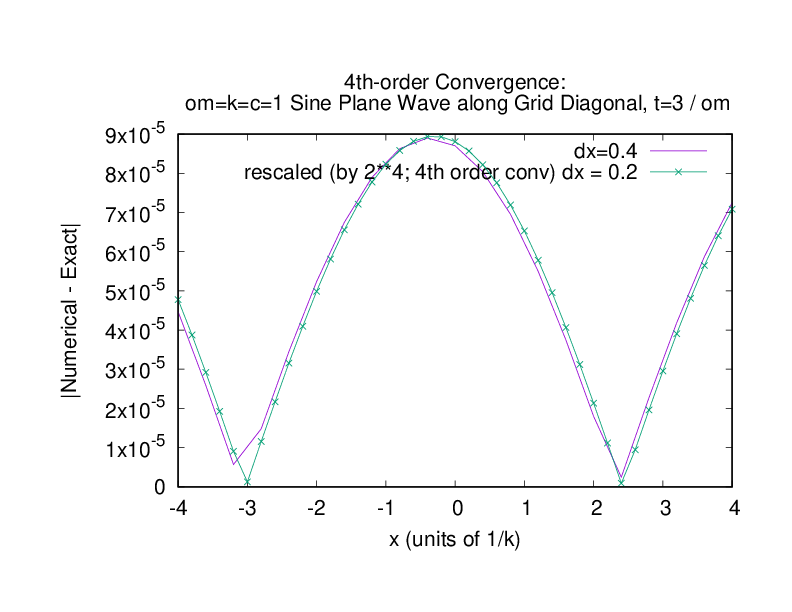

In [8]:
from wand.image import Image as WImage
WImage(filename='WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests/out-RK4-FD4-3D.pdf')